In [ ]:
pip install tensorflow

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TCS ion internship/dataset/IMDB Dataset.csv", error_bad_lines=False)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from bs4 import BeautifulSoup
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

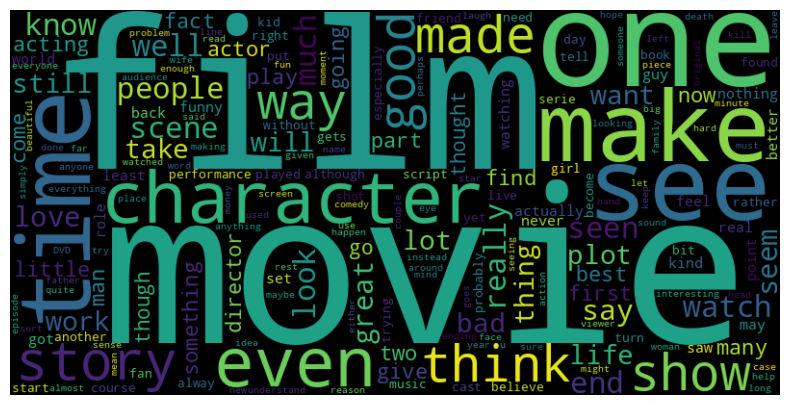

In [ ]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt

# Assuming df['review'] contains a series of text reviews
text = ' '.join(df['review'])

wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# make the max word length to be constant
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 500

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['sentiment']=le.fit_transform(df['sentiment'])

In [ ]:
df.head()             # 1 for positive and 0 for negative

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)

#the tokenizer is learning the vocabulary based on the words present in df['review']
tokenizer.fit_on_texts(df['review'])

#This converts the text in df['review'] to sequences of integers.
sequences =  tokenizer.texts_to_sequences(df['review'])

#retrieves a dictionary mapping words to their integer index.
word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = np.asarray(df['sentiment'])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 126496
Shape of data tensor: (50000, 500)
Shape of label tensor: (50000,)
[1 1 1 ... 0 0 0]


In [ ]:
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
embeddings_index = {}
f = open(os.path.join("/content/drive/MyDrive/TCS ion internship/dataset/glove.6B.100d.txt"), 'r')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# the dimension of vectors to be used
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
EMBEDDING_DIM = 100
# filter sizes of the different conv layers
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100


# dropout probability
drop = 0.5
batch_size = 30
epochs = 15

In [ ]:
# Define the model
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=50, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu'),
    Flatten(),  # Flatten layer replaces GlobalMaxPooling1D
    Dense(1, activation='sigmoid')  # Binary classification, so use 1 output node with sigmoid activation
])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Convert labels to NumPy array
y = tf.convert_to_tensor(labels)

In [ ]:
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)

In [ ]:
print("Training Model...")
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))


Training Model...
Epoch 1/15
1334/1334 [==============================] - 73s 54ms/step - loss: 0.3097 - accuracy: 0.8579 - val_loss: 0.2326 - val_accuracy: 0.9049
Epoch 2/15
1334/1334 [==============================] - 70s 53ms/step - loss: 0.1655 - accuracy: 0.9365 - val_loss: 0.2495 - val_accuracy: 0.9012
Epoch 3/15
1334/1334 [==============================] - 70s 52ms/step - loss: 0.0836 - accuracy: 0.9698 - val_loss: 0.3421 - val_accuracy: 0.8897
Epoch 4/15
1334/1334 [==============================] - 69s 52ms/step - loss: 0.0331 - accuracy: 0.9898 - val_loss: 0.4568 - val_accuracy: 0.8875
Epoch 5/15
1334/1334 [==============================] - 71s 53ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.5880 - val_accuracy: 0.8875
Epoch 6/15
1334/1334 [==============================] - 78s 59ms/step - loss: 0.0157 - accuracy: 0.9944 - val_loss: 0.7141 - val_accuracy: 0.8826
Epoch 7/15
1334/1334 [==============================] - 69s 52ms/step - loss: 0.0174 - accuracy: 0.9945 - 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Accuracy: {accuracy * 100:.2f}%')

313/313 [==============================] - 5s 16ms/step - loss: 1.2654 - accuracy: 0.8836
Accuracy: 88.36%


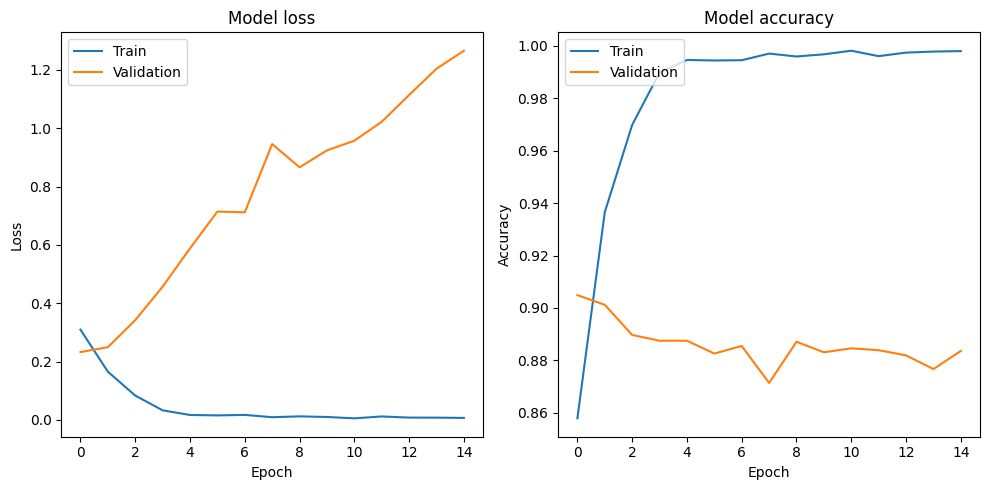

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [ ]:
# Make predictions on the test data
y_prob = loaded_model.predict(x_val)

# Assuming binary classification, threshold the probabilities
y_pred = np.round(y_prob)


# Generate the classification report
report = classification_report(y_val, y_pred)

# Print the classification report
print(report)


313/313 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.90      0.89      5061

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
# Save the model using the h5 format (recommended for TensorFlow models)
model.save('sentiment_cnn_model.h5')

In [ ]:
# Load the model using TensorFlow
loaded_model = tf.keras.models.load_model('sentiment_cnn_model.h5')

# Store the model using pickle
with open('sentiment_cnn_model.pkl', 'wb') as model_file:
    pickle.dump(loaded_model, model_file)
